In [1]:
import parametrization as param
from CentralStreamingModel.utils.read_probabilities import VD, VD_los
from CentralStreamingModel.projection import generating_moments
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import simps
from scipy.interpolate import interp1d, interp2d
import seaborn as sns
from CentralStreamingModel.moments import moments2model, read
from scipy.interpolate import UnivariateSpline
from halotools.mock_observables import tpcf_multipole

sns.set_context('talk')

In [2]:
n_boxes = 5
boxsize = 1024
snapshot = 0
rm = read.Read_Mean(n_boxes, boxsize, snapshot)

In [3]:
# Set correlation function to zero
rm.tpcf_dict['tpcf'] = np.zeros_like(rm.tpcf_dict['tpcf'])

In [4]:
parameters = [r'$m_r$',r'$c_r$',r'$c_t$']

In [5]:
ex = generating_moments.Expectations(rm.r, rm.v_r, rm.v_t,
                                     rm.jointpdf_rt)


In [6]:
s = np.arange(0.,50.,1)
mu = np.linspace(0.,1,60)


In [7]:
moments_projected = generating_moments.project(ex, rm.r_perp,
                                    rm.r_parallel)

In [8]:
gaussian = moments2model.Model(rm, moments_projected, model='gaussian')


In [9]:
gaussian.multipoles(s, mu) 

In [10]:
m_r = ex.moment(1,0)(rm.r)
c_r = ex.central_moment(2,0)(rm.r)
c_t = ex.central_moment(0,2)(rm.r)

## FIT THE LOWEST THREE MOMENTS

In [48]:
def fitting_m_r(r, a,c,d):
    return a * r**(0.5) + c*r + d

0.11102734537588807


Text(40,-2,'$m_r(r) = A \\sqrt{r} + B r + C$')

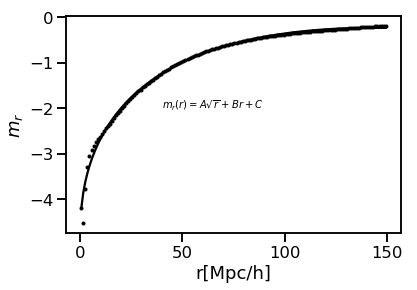

In [56]:
idx = 0

_, chi, popt_m_r = param.plot(fitting_m_r, rm.r, m_r, 
        'black', 'Halos',parameters[idx], limit = 20)
#plt.text(40, -2, r'$\chi^2_\nu $ = %.2f'%chi, fontdict=dict(color='black'))
plt.text(40,-2,r'$m_r(r) = A \sqrt{r} + B r + C$')

In [58]:
def fitting_c(r, a, b,c):
    return a * r**b  + c

2.314160745363169


(6, 25)

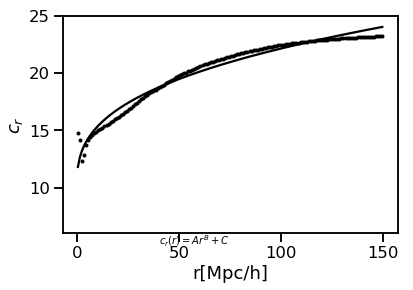

In [59]:
idx = 1

_, chi, popt_c_r = param.plot(fitting_c, rm.r, c_r, 
        'black', 'Halos',parameters[idx], limit = 0)
plt.text(40,5,r'$c_r(r) = A r^B + C$')

plt.ylim(6,25)

3.8706306673543964


Text(10,15,'$c_t(r) = A r^B + C$')

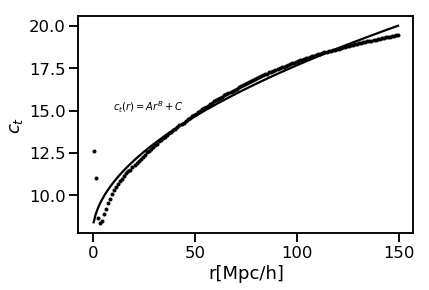

In [17]:
idx = 2

_, chi, popt_c_t = param.plot(fitting_c, rm.r, c_t, 
        'black', 'Halos',parameters[idx], limit = 0)
plt.text(10,15,r'$c_t(r) = A r^B + C$')


## GENERATE GAUSSIAN STREAMING MODEL WITH FITTED MOMENTS

In [18]:

moments_reduced = np.zeros((len(rm.r_perp), len(rm.r_parallel), 3))


for i, rper in enumerate(rm.r_perp):                                                                                                   
    for j, rpar in enumerate(rm.r_parallel):                                                                                           

        r_ = np.sqrt(rper**2 + rpar**2)                                                                                             
        mu_value = rpar/r_                                                                                                                


        moments_reduced[i,j, 0] = fitting_m_r(r_, *popt_m_r) * mu_value                                                                                  

        moments_reduced[i,j, 1] = fitting_c(r_, *popt_c_r) * mu_value**2 \
                            + fitting_c(r_, *popt_c_t) * (1 - mu_value**2) 



In [20]:
gaussian_reduced = moments2model.Model(rm, moments_reduced, model = 'gaussian')

In [21]:
gaussian_reduced.multipoles(s, mu) 

In [22]:
measured = moments2model.Model(rm, moments_projected, 'measured')

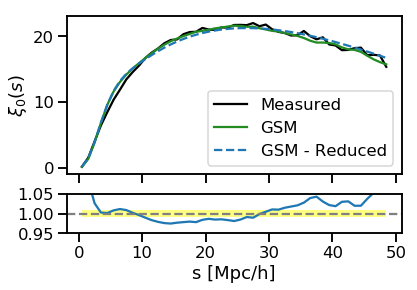

In [23]:
fig, (ax1, ax2) = plt.subplots(nrows=2,sharex = True, squeeze = True,
                          gridspec_kw = {'height_ratios':[4,1]})

ax1.plot(measured.s_c, measured.s_c * measured.s_c * measured.mono,
        color = 'black', label = 'Measured')

ax1.plot(gaussian.s_c, gaussian.s_c * gaussian.s_c * gaussian.mono,
        color = 'forestgreen', label = 'GSM')
ax1.plot(gaussian_reduced.s_c, 
         gaussian_reduced.s_c * gaussian_reduced.s_c * gaussian_reduced.mono,
        label = 'GSM - Reduced', linestyle='dashed')

ax2.plot(gaussian_reduced.s_c[1:], gaussian_reduced.mono[1:]/gaussian.mono[1:])
ax2.axhline(y = 1., linestyle='dashed', color='gray')
ax1.set_ylabel(r'$\xi_0 (s)$')
ax2.set_xlabel(r's [Mpc/h]')
ax2.fill_between(gaussian.s_c,0.99, 1.01, facecolor = 'yellow', alpha = 0.5)
ax2.set_ylim(0.95,1.05)
ax1.legend()


Text(0.5,0,'s [Mpc/h]')

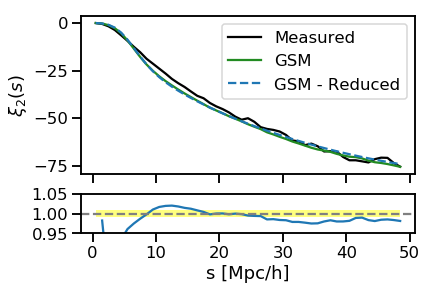

In [24]:
fig, (ax1, ax2) = plt.subplots(nrows=2,sharex = True, squeeze = True,
                          gridspec_kw = {'height_ratios':[4,1]})

ax1.plot(measured.s_c, measured.s_c * measured.s_c * measured.quad,
        color = 'black', label = 'Measured')

ax1.plot(gaussian.s_c, gaussian.s_c * gaussian.s_c * gaussian.quad,
         color = 'forestgreen', label = 'GSM')
ax1.plot(gaussian_reduced.s_c, gaussian_reduced.s_c * gaussian_reduced.s_c * gaussian_reduced.quad,
                label = 'GSM - Reduced', linestyle='dashed')

ax1.legend()
ax2.plot(gaussian_reduced.s_c[1:], gaussian_reduced.quad[1:]/gaussian.quad[1:])
ax2.axhline(y = 1., linestyle='dashed', color='gray')
ax2.fill_between(gaussian.s_c,0.99, 1.01, facecolor = 'yellow', alpha = 0.5)
ax2.set_ylim(0.95,1.05)

ax1.set_ylabel(r'$\xi_2 (s)$')
ax2.set_xlabel(r's [Mpc/h]')

Text(0.5,0,'s [Mpc/h]')

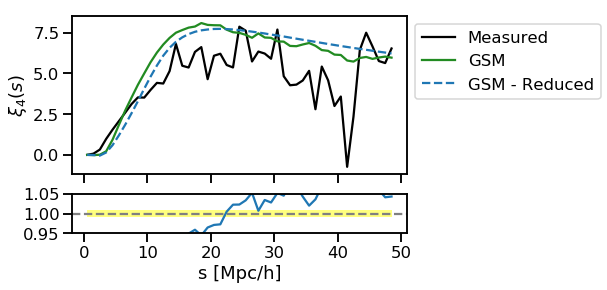

In [25]:
fig, (ax1, ax2) = plt.subplots(nrows=2,sharex = True, squeeze = True,
                          gridspec_kw = {'height_ratios':[4,1]})

ax1.plot(measured.s_c, measured.s_c * measured.s_c * measured.hexa,
        color = 'black', label = 'Measured')
ax1.plot(gaussian.s_c, gaussian.s_c * gaussian.s_c * gaussian.hexa,
         color = 'forestgreen', label = 'GSM')
ax1.plot(gaussian_reduced.s_c, gaussian_reduced.s_c * gaussian_reduced.s_c * gaussian_reduced.hexa,
                label = 'GSM - Reduced', linestyle='dashed')
ax1.legend(bbox_to_anchor=(1,1))

ax2.plot(gaussian_reduced.s_c[1:], gaussian_reduced.hexa[1:]/gaussian.hexa[1:])
ax2.axhline(y = 1., linestyle='dashed', color='gray')
ax2.fill_between(gaussian.s_c,0.99, 1.01, facecolor = 'yellow', alpha = 0.5)
ax2.set_ylim(0.95,1.05)

ax1.set_ylabel(r'$\xi_4 (s)$')
ax2.set_xlabel(r's [Mpc/h]')

## TAYLOR EXPANSION

In [73]:
def first_mu_prime(s, mu):
    return (1 - mu**2)/s


def first_m1_dot(s, popt_m_r):
    a, b, c = popt_m_r
    return 0.5 * a/np.sqrt(s) + b


def first_m1_prime(s, mu, popt_m_r):
    
    return first_mu_prime(s,mu) * fitting_m_r(s, *popt_m_r) + \
            mu**2 * first_m1_dot(s, popt_m_r)

In [74]:
def second_mu_prime(s, mu):
    return -3 * (1-mu**2)*mu/s**2
    
def second_s_prime(s,mu):
    return (1 - mu**2)/s

def second_m1_dot(s, popt_m_r):
    a, b, c = popt_m_r
    return -1./4.* a * s**(-3./2.)

def second_m1_prime(s, mu, popt_m_r):
    return second_mu_prime(s, mu) * fitting_m_r(s, *popt_m_r)  + \
            2 * first_mu_prime(s, mu) * mu * first_m1_dot(s, popt_m_r) + \
            mu * (second_s_prime(s, mu) * first_m1_dot(s, popt_m_r) + \
                  mu**2 * second_m1_dot(s, popt_m_r))

In [75]:
def first_dot_c(s, popt_c):
    a, b, c = popt_c    
    return a * b * s **(b-1)
    
def second_dot_c(s, popt_c):
    a, b, c = popt_c    
    return a * b * (b-1) * s **(b-2)

def second_c2_prime(s, mu, popt_c_r, popt_c_t):
    
    return (fitting_c(s, *popt_c_r) - fitting_c(s, *popt_c_t))* (2 * first_mu_prime(s, mu)**2 \
                                                                 + 2 * mu *second_mu_prime(s,mu)) + \
            (first_dot_c(s, popt_c_r) - first_dot_c(s, popt_c_t)) * 4 *mu**2 * first_mu_prime(s, mu) + \
            mu**2 * (second_s_prime(s,mu) *first_dot_c(s, popt_c_r) + mu**2 * second_dot_c(s, popt_c_r) ) +\
            (1-mu)**2 * (second_s_prime(s,mu) *first_dot_c(s, popt_c_t) + mu**2 * second_dot_c(s, popt_c_t) )
            

In [76]:
def second_m2_prime(s, mu, popt_m_r, popt_c_r, popt_c_t):
    
    return second_c2_prime(s, mu, popt_c_r, popt_c_t) + \
            2 * first_m1_prime(s, mu, popt_m_r)**2 + \
            2 *  fitting_m_r(s, *popt_m_r) * second_m1_prime(s, mu, popt_m_r)

In [103]:
def simple_approximation(order):
    
    s_c = 0.5* (s[1:] + s[:-1])
    mu_c = 0.5* (mu[1:] + mu[:-1])
    s_mu_approx = np.zeros((len(s_c), len(mu_c)))


    for i, s_value in enumerate(s_c):
    
        for j, mu_value in enumerate(mu_c):
            

            s_mu_approx[i, j] = - first_m1_prime(s_value, mu_value, popt_m_r)
            
            if order != 1:
                s_mu_approx[i, j] += 0.5 * second_m2_prime(s_value, mu_value,
                                            popt_m_r, popt_c_r, popt_c_t)

       
    mono_approx = tpcf_multipole(s_mu_approx, mu, order = 0)
    quad_approx = tpcf_multipole(s_mu_approx, mu, order = 2)
    hexa_approx = tpcf_multipole(s_mu_approx, mu, order = 4)

    return s_mu_approx, mono_approx, quad_approx, hexa_approx

In [104]:
s_mu_approx_1, mono_1, quad_1, hexa_1 = simple_approximation(1)

s_mu_approx_2, mono_2, quad_2, hexa_2 = simple_approximation(2)


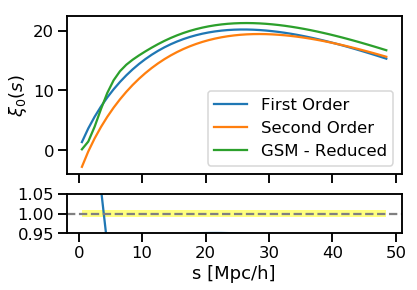

In [79]:
fig, (ax1, ax2) = plt.subplots(nrows=2,sharex = True, squeeze = True,
                          gridspec_kw = {'height_ratios':[4,1]})


ax1.plot(gaussian.s_c, gaussian.s_c * gaussian.s_c * mono_1, label = 'First Order')
ax1.plot(gaussian.s_c, gaussian.s_c * gaussian.s_c * mono_2, label = 'Second Order')

ax1.plot(gaussian_reduced.s_c, gaussian_reduced.s_c * gaussian_reduced.s_c * gaussian_reduced.mono, 
         label = 'GSM - Reduced')

ax2.plot(gaussian_reduced.s_c[1:], mono_1[1:]/gaussian_reduced.mono[1:])

ax2.plot(gaussian_reduced.s_c[1:], mono_2[1:]/gaussian_reduced.mono[1:])

ax2.axhline(y = 1., linestyle='dashed', color='gray')
ax1.set_ylabel(r'$\xi_0 (s)$')
ax2.set_xlabel(r's [Mpc/h]')
ax2.fill_between(gaussian.s_c,0.99, 1.01, facecolor = 'yellow', alpha = 0.5)
ax2.set_ylim(0.95,1.05)

ax1.legend()

(0.95, 1.05)

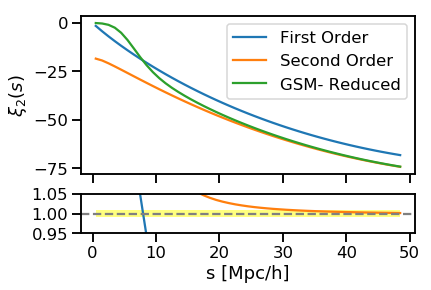

In [64]:
fig, (ax1, ax2) = plt.subplots(nrows=2,sharex = True, squeeze = True,
                          gridspec_kw = {'height_ratios':[4,1]})


ax1.plot(gaussian.s_c, gaussian.s_c * gaussian.s_c * quad_1, label = 'First Order')
ax1.plot(gaussian.s_c, gaussian.s_c * gaussian.s_c * quad_2, label = 'Second Order')

ax1.plot(gaussian_reduced.s_c, gaussian_reduced.s_c * gaussian_reduced.s_c * gaussian_reduced.quad,
         label = 'GSM- Reduced')

ax2.plot(gaussian_reduced.s_c[1:], quad_1[1:]/gaussian_reduced.quad[1:])

ax2.plot(gaussian_reduced.s_c[1:], quad_2[1:]/gaussian_reduced.quad[1:])

ax1.legend()
ax2.axhline(y = 1., linestyle='dashed', color='gray')
ax1.set_ylabel(r'$\xi_2 (s)$')
ax2.set_xlabel(r's [Mpc/h]')
ax2.fill_between(gaussian.s_c,0.99, 1.01, facecolor = 'yellow', alpha = 0.5)
ax2.set_ylim(0.95,1.05)

(0.95, 1.05)

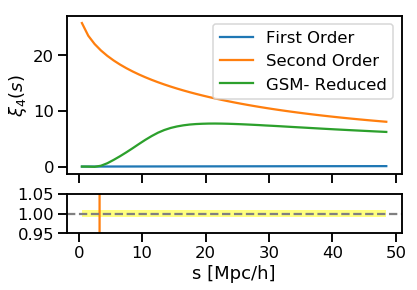

In [65]:
fig, (ax1, ax2) = plt.subplots(nrows=2,sharex = True, squeeze = True,
                          gridspec_kw = {'height_ratios':[4,1]})


ax1.plot(gaussian.s_c, gaussian.s_c * gaussian.s_c * hexa_1, label = 'First Order')
ax1.plot(gaussian.s_c, gaussian.s_c * gaussian.s_c * hexa_2, label = 'Second Order')

ax1.plot(gaussian_reduced.s_c, gaussian_reduced.s_c * gaussian_reduced.s_c * gaussian_reduced.hexa,
         label = 'GSM- Reduced')

ax2.plot(gaussian_reduced.s_c[1:], hexa_1[1:]/gaussian_reduced.hexa[1:])

ax2.plot(gaussian_reduced.s_c[1:], hexa_2[1:]/gaussian_reduced.hexa[1:])

ax1.legend()
ax2.axhline(y = 1., linestyle='dashed', color='gray')
ax1.set_ylabel(r'$\xi_4 (s)$')
ax2.set_xlabel(r's [Mpc/h]')
ax2.fill_between(gaussian.s_c,0.99, 1.01, facecolor = 'yellow', alpha = 0.5)
ax2.set_ylim(0.95,1.05)

In [217]:
special_case, special_case_2 = [], []
bin_value = 58
mu_value = 0.5 * (gaussian_reduced.mu[bin_value] + gaussian_reduced.mu[bin_value + 1])
s_c = 0.5* (s[1:] + s[:-1])
mu_c = 0.5* (mu[1:] + mu[:-1])

for i, s_value in enumerate(s_c):
    special_case.append(- first_m1_prime(s_value, mu_value, popt_m_r))
    special_case_2.append(- first_m1_prime(s_value, mu_value, popt_m_r) + \
                         0.5 * second_m2_prime(s_value, mu_value, popt_m_r, popt_c_r, popt_c_t))

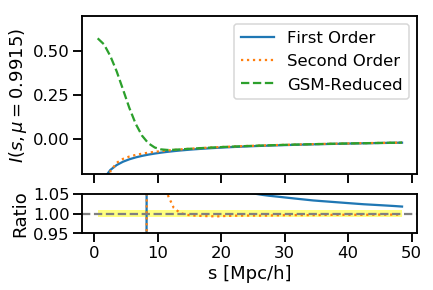

In [218]:
fig, (ax1, ax2) = plt.subplots(nrows=2,sharex = True, squeeze = True,
                          gridspec_kw = {'height_ratios':[4,1]})
ax1.plot(s_c, special_case, label = 'First Order')
ax1.plot(s_c, special_case_2, label = 'Second Order', linestyle='dotted')

ax1.plot(s_c, gaussian_reduced.s_mu[:,bin_value], label = 'GSM-Reduced', linestyle='dashed')
ax2.set_xlabel('s [Mpc/h]')
ax1.set_ylabel(f'$I(s, \mu = {mu_value:.4f})$')
ax1.legend()
ax1.set_ylim(-0.2,0.7)
ax2.plot(s_c, special_case/gaussian_reduced.s_mu[:,bin_value])
ax2.plot(s_c, special_case_2/gaussian_reduced.s_mu[:,bin_value], linestyle='dotted')
ax2.set_ylim(0.95, 1.05)
ax2.axhline(y = 1., linestyle='dashed', color='gray')
ax2.set_ylabel('Ratio')
ax2.fill_between(gaussian.s_c,0.99, 1.01, facecolor = 'yellow', alpha = 0.5)
